In [1]:
# Online training of a logistic regression model
# using Assumed Density Filtering (ADF).
# We compare the ADF result with MCMC sampling
# For further details, see the ADF paper:
#   * O. Zoeter, "Bayesian Generalized Linear Models in a Terabyte World,"
#     2007 5th International Symposium on Image and Signal Processing and Analysis, 2007,
#     pp. 435-440, doi: 10.1109/ISPA.2007.4383733.
# of the posterior distribution

# Author: Gerardo Durán-Martín (@gerdm)
import os
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax import random
from jax.scipy.stats import norm
from jax.scipy.optimize import minimize
import seaborn as sns

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

In [2]:
from probml_utils import savefig, latexify

# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures"
# latexify(width_scale_factor=3, fig_height=1.5)  # for book

$$
    \eta_t = \sigma({\bf w}_t^T {\bf x}_t) + q_t; q_t \sim \mathcal{N}(0, v_t)
$$

$$
    p({\bf w}_t \vert {\bf w}_{t-1}) = \prod_j\mathcal{N}(w_t^j \vert  \mu_{t \vert t-1}, \tau_{t \vert t-1}^j)
$$

In [3]:
def make_dataset(seed=135):
    np.random.seed(seed)
    N = 30
    mu1 = np.hstack((np.ones((N, 1)), 5 * np.ones((N, 1))))
    mu2 = np.hstack((-5 * np.ones((N, 1)), np.ones((N, 1))))
    class1_std = 1
    class2_std = 1.1
    X_1 = np.add(class1_std * np.random.randn(N, 2), mu1)
    X_2 = np.add(2 * class2_std * np.random.randn(N, 2), mu2)
    X = np.vstack((X_1, X_2))
    y = np.vstack((np.ones((N, 1)), np.zeros((N, 1))))
    return X, y.ravel()


def log_joint(w, Phi, y, alpha):
    an = Phi @ w
    log_an = jax.nn.log_sigmoid(an)
    log_likelihood_term = y * log_an + (1 - y) * jnp.log(1 - jax.nn.sigmoid(an))
    log_prior_term = -(alpha * w @ w / 2)
    return log_prior_term + log_likelihood_term.sum()


def laplace_posterior(key, Phi, y, alpha=1.0, init_noise=1.0):
    N, M = Phi.shape
    w0 = random.multivariate_normal(key, jnp.zeros(M), jnp.eye(M) * init_noise)
    E = lambda w: -log_joint(w, Phi, y, alpha) / len(y)
    res = minimize(E, w0, method="BFGS")
    w_laplace = res.x
    SN = jax.hessian(E)(w_laplace)
    return w_laplace, SN


def plot_posterior_predictive(ax, X, Xspace, Zspace, title, colors, cmap="viridis"):
    ax.contourf(*Xspace, Zspace, cmap=cmap, levels=20)
    ax.scatter(*X.T, c=colors, edgecolors="gray", s=80)
    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()

In [4]:
def h(n, a, b):
    return (b - a) / 2**n


def romb_row_init(R_prev: float, n: int, a: int, b: int, f):
    k_points = jnp.arange(1, 2 ** (n - 1) + 1)
    eval_points = a + (2 * k_points - 1) * h(n, a, b)
    R_init = R_prev / 2 + h(n, a, b) * f(eval_points).sum()

    return R_init


def romb(f, a, b, n_iterations=4):
    """
    O(x^2) implementation of Romberg's method.
    Reference: https://en.wikipedia.org/wiki/Romberg%27s_method
    """
    R_values = jnp.zeros((n_iterations + 1, n_iterations + 1))

    R = h(1, a, b) * (f(a) + f(b))
    R_values = R_values.at[0, 0].set(R)

    for n in range(1, n_iterations + 1):
        R = romb_row_init(R_values[n - 1, 0], n, a, b, f)
        R_values = R_values.at[n, 0].set(R)

        for m in range(1, n + 1):
            R = (4**m * R_values[n, m - 1] - R_values[n - 1, m - 1]) / (4**m - 1)
            R_values = R_values.at[n, m].set(R)
    I = R_values[-1, -1]
    return I

In [5]:
def Zt_func(eta, y, mu, v):
    log_term = y * jax.nn.log_sigmoid(eta) + (1 - y) * jnp.log1p(-jax.nn.sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)

    return jnp.exp(log_term)


def mt_func(eta, y, mu, v, Zt):
    log_term = y * jax.nn.log_sigmoid(eta) + (1 - y) * jnp.log1p(-jax.nn.sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)

    return eta * jnp.exp(log_term) / Zt


def vt_func(eta, y, mu, v, Zt):
    log_term = y * jax.nn.log_sigmoid(eta) + (1 - y) * jnp.log1p(-jax.nn.sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)

    return eta**2 * jnp.exp(log_term) / Zt


def adf_step(state, xs, prior_variance, lbound, ubound):
    mu_t, tau_t = state
    Phi_t, y_t = xs

    mu_t_cond = mu_t
    tau_t_cond = tau_t + prior_variance

    # prior predictive distribution
    m_t_cond = (Phi_t * mu_t_cond).sum()
    v_t_cond = (Phi_t**2 * tau_t_cond).sum()

    v_t_cond_sqrt = jnp.sqrt(v_t_cond)

    # Moment-matched Gaussian approximation elements
    Zt = romb(lambda eta: Zt_func(eta, y_t, m_t_cond, v_t_cond_sqrt), lbound, ubound)

    mt = romb(lambda eta: mt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), lbound, ubound)

    vt = romb(lambda eta: vt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), lbound, ubound)
    vt = vt - mt**2

    # Posterior estimation
    delta_m = mt - m_t_cond
    delta_v = vt - v_t_cond
    a = Phi_t * tau_t_cond / (Phi_t**2 + tau_t_cond).sum()

    mu_t = mu_t_cond + a * delta_m
    tau_t = tau_t_cond + a**2 * delta_v

    return (mu_t, tau_t), (mu_t, tau_t)

In [6]:
def sample_posterior_predictive2d(key, domain, mean, cov, n_samples=5000):
    samples = jax.random.multivariate_normal(key, mean, cov, (n_samples,))
    Z = jax.nn.sigmoid(jnp.einsum("mij,sm->sij", domain, samples))
    Z = Z.mean(axis=0)
    return Z


def plot_adf_post_laplace(
    mu_hist, tau_hist, w_fix, lcolors, label, legend_font_size=12, bb1=(1.1, 1.1), bb2=(1, 0.3), bb3=(0.6, 0.3)
):

    elements = (mu_hist.T, tau_hist.T, w_fix, lcolors)
    n_datapoints = len(mu_hist)
    timesteps = jnp.arange(n_datapoints) + 1

    for k, (wk, Pk, wk_fix, c) in enumerate(zip(*elements)):
        fig_weight_k, ax = plt.subplots()
        ax.errorbar(timesteps, wk, jnp.sqrt(Pk), c=c, label=f"$w_{k}$ online (adf)")
        ax.axhline(y=wk_fix, c=c, linestyle="dotted", label=f"$w_{k}$ batch (Laplace)", linewidth=3)

        ax.set_xlim(1, n_datapoints)

        ax.set_xlabel("number samples", fontsize=15)
        ax.set_ylabel("weights", fontsize=15)
        ax.tick_params(axis="both", which="major", labelsize=15)
        sns.despine()
        if k == 0:
            ax.legend(frameon=False, loc="upper right", bbox_to_anchor=bb1, fontsize=legend_font_size)

        elif k == 1:
            ax.legend(frameon=False, bbox_to_anchor=bb2, fontsize=legend_font_size)

        elif k == 2:
            ax.legend(frameon=False, bbox_to_anchor=bb3, fontsize=legend_font_size)

        plt.tight_layout()
        pml.savefig(label.format(k=k))
        plt.savefig(label.format(k=k) + ".pdf", bbox_inches="tight", pad_inches=0.0)

## Initial setup

In [7]:
key = jax.random.PRNGKey(314)
key_pp, key_shuffle, key = jax.random.split(key, 3)
X, y = make_dataset()
n_datapoints = len(y)

Phi = jnp.c_[jnp.ones(n_datapoints)[:, None], X]

In [8]:
# Predictive domain
xmin, ymin = X.min(axis=0) - 0.1
xmax, ymax = X.max(axis=0) + 0.1
step = 0.1
Xspace = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
_, nx, ny = Xspace.shape
Phispace = jnp.concatenate([jnp.ones((1, nx, ny)), Xspace])

## Laplace estimation

In [9]:
alpha = 2.0
w_laplace, SN = laplace_posterior(key, Phi, y, alpha=alpha)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


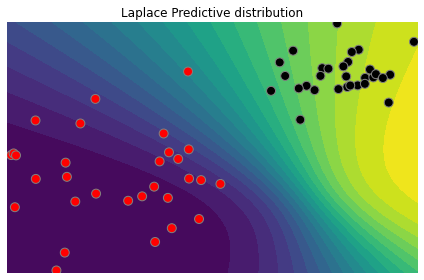

In [10]:
fig_adf, ax = plt.subplots()

# Laplace posterior predictive distribution
Z_laplace = sample_posterior_predictive2d(key_pp, Phispace, w_laplace, SN)
title = "Laplace Predictive distribution"
colors = ["black" if el else "red" for el in y]
plot_posterior_predictive(ax, X, Xspace, Z_laplace, title, colors, cmap="viridis")
pml.savefig("logistic_regression_surface_laplace.pdf")

## ADF Inference

In [11]:
prior_variance = 0.00

n_datapoints, ndims = Phi.shape
lbound, ubound = -12.0, 12.0
mu_0 = jnp.zeros(ndims) * 0.0
tau_0 = jnp.ones(ndims) * 1.0

init_state = (mu_0, tau_0)

### Run with original data

ADF weights
[-0.13612427  1.217591    0.71540165]


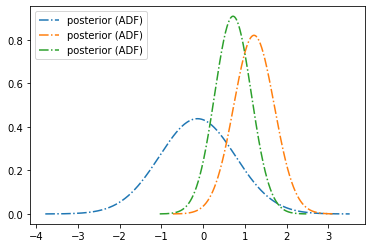

In [12]:
xs = (Phi, y)
colors = ["black" if el else "red" for el in y]

adf_loop = partial(adf_step, prior_variance=prior_variance, lbound=lbound, ubound=ubound)
(mu_t, tau_t), (mu_t_hist, tau_t_hist) = jax.lax.scan(adf_loop, init_state, xs)
print("ADF weights")
print(mu_t)

# ** Plotting predictive distribution **
fig, ax = plt.subplots()
for i in range(ndims):
    mean, std = mu_t[i], jnp.sqrt(tau_t[i])
    ax = fig.gca()
    x = jnp.linspace(mean - 4 * std, mean + 4 * std, 500)
    ax.plot(x, norm.pdf(x, mean, std), label="posterior (ADF)", linestyle="dashdot")
    ax.legend()

### ADF predictive distribution

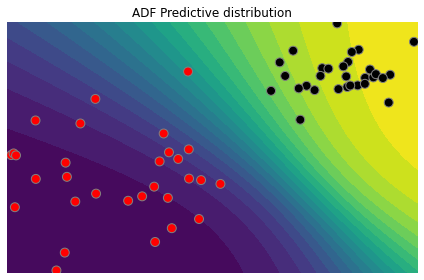

In [13]:
fig_adf, ax = plt.subplots()

# ADF posterior predictive distribution
Z_adf = sample_posterior_predictive2d(key_pp, Phispace, mu_t, jnp.diag(tau_t))
title = "ADF Predictive distribution"
plot_posterior_predictive(ax, X, Xspace, Z_adf, title, colors, cmap="viridis")
pml.savefig("logistic_regression_surface_adf.pdf")

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


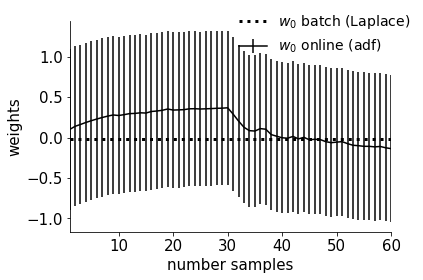

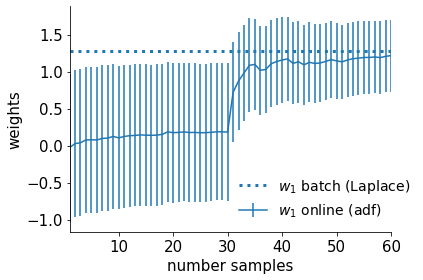

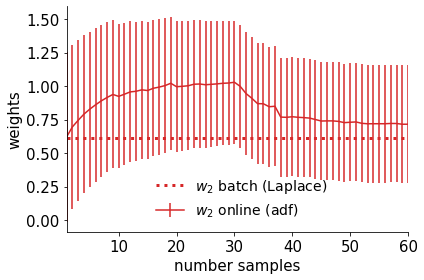

In [14]:
lcolors = ["black", "tab:blue", "tab:red"]
label = "logistic_regression_hist_adf_w{k}"
plot_adf_post_laplace(
    mu_t_hist, tau_t_hist, w_laplace, lcolors, label, legend_font_size=14, bb2=(1.1, 0.3), bb3=(0.8, 0.3)
)

## Run with shuffled data

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


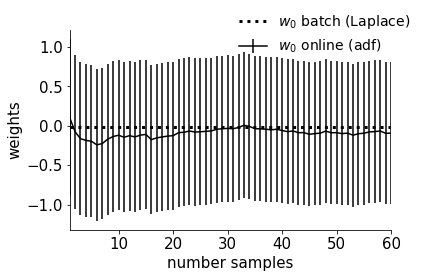

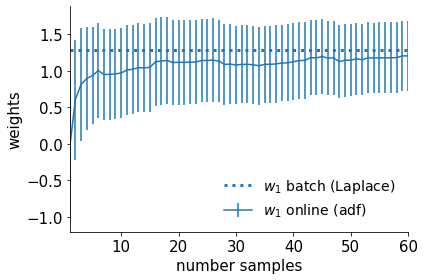

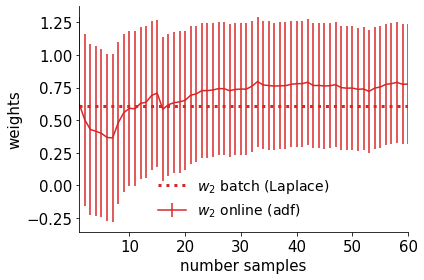

In [15]:
D = jnp.c_[Phi, y]
D = jax.random.permutation(key_shuffle, D, axis=0, independent=False)
Phi_shuff, y_shuff = D[:, :-1], D[:, -1]
xs = (Phi_shuff, y_shuff)
init_state = (mu_0, tau_0)

adf_loop = partial(adf_step, prior_variance=prior_variance, lbound=lbound, ubound=ubound)
(mu_t, tau_t), (mu_t_hist, tau_t_hist) = jax.lax.scan(adf_loop, init_state, xs)

label = "logistic_regression_hist_adf_shuffled_w{k}"
plot_adf_post_laplace(
    mu_t_hist, tau_t_hist, w_laplace, lcolors, label, legend_font_size=14, bb1=(1.1, 1.15), bb3=(0.8, 0.3)
)

# Save

In [16]:
!zip -q -r /content/adf-figures.zip /content/adf-figures


zip error: Nothing to do! (try: zip -q -r /content/adf-figures.zip . -i /content/adf-figures)
